In [ ]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys
import logging

import numpy as np
import pandas as pd

from neuclease.dvid import DvidInstanceInfo, fetch_split_supervoxel_sizes, fetch_complete_mappings
from neuclease.merge_table import load_supervoxel_sizes, compute_body_sizes

In [6]:
handler = logging.StreamHandler(sys.stdout)
root_logger = logging.getLogger()
root_logger.handlers = []
root_logger.addHandler(handler)
root_logger.setLevel(logging.INFO)
logging.getLogger('kafka').setLevel(logging.WARNING)

### Load Original supervoxel sizes

In [7]:
orig_sizes_file = '/groups/flyem/data/scratchspace/copyseg-configs/labelmaps/hemibrain/8nm/compute-8nm-extended-fixed-STATS-ONLY-20180402.192015/supervoxel-sizes.h5'
%time orig_sv_sizes = load_supervoxel_sizes(orig_sizes_file)
total_voxel_count = orig_sv_sizes.sum()

Volume contains 188243164 supervoxels and 22.5 Teravoxels in total
CPU times: user 662 ms, sys: 1.83 s, total: 2.49 s
Wall time: 5.92 s


### Fetch Supervoxel split fragment sizes

In [30]:
# Initial agglo node
instance_info = DvidInstanceInfo('emdata3:8900', 'ac90', 'segmentation')

# Latest production node
instance_info = DvidInstanceInfo('emdata3:8900', '7254f5a8aacf4e6f804dcbddfdac4f7f', 'segmentation')

# Proofreader test node
instance_info = ('emdata1:8400', 'ecbedddd08034db8b0b0f1529b578d96', 'segmentation')

In [9]:
split_fragment_sizes = fetch_split_supervoxel_sizes(*instance_info)

Reading kafka messages from kafka.int.janelia.org:9092 for emdata3:8900 / 7254f5a8aacf4e6f804dcbddfdac4f7f / segmentation
Reading 517916 kafka messages took 18.0354061126709 seconds
Fetching sizes for 5910 split supervoxels...
Fetching sizes for 5910 split supervoxels took 0:00:11.705968


### Combine orig/split sizes

In [10]:
sv_sizes = pd.concat((orig_sv_sizes, split_fragment_sizes))

In [11]:
assert sv_sizes.index.dtype == np.uint64
assert sv_sizes.dtype == np.uint32

### Fetch mapping

In [31]:
mapping = fetch_complete_mappings(*instance_info)

Reading kafka messages from kafka.int.janelia.org:9092 for emdata1:8400 / ecbedddd08034db8b0b0f1529b578d96 / segmentation
Reading 517916 kafka messages took 16.13109564781189 seconds
Fetching http://emdata1:8400/api/node/ecbedddd08034db8b0b0f1529b578d96/segmentation/mappings...
Fetching http://emdata1:8400/api/node/ecbedddd08034db8b0b0f1529b578d96/segmentation/mappings took 0:00:32.505847
Parsing mapping...
Parsing mapping took 0:00:07.705811
Constructing missing identity-mappings...
Constructing missing identity-mappings took 0:00:25.282152


### Compute body sizes

In [32]:
body_sizes = compute_body_sizes(sv_sizes, mapping)

Dropping unknown supervoxels
Applying sizes to mapping
Aggregating sizes by body


In [34]:
body_sizes.to_csv(f'/nrs/flyem/bergs/tmp/body-sizes-{instance_info[1][:4]}.csv')

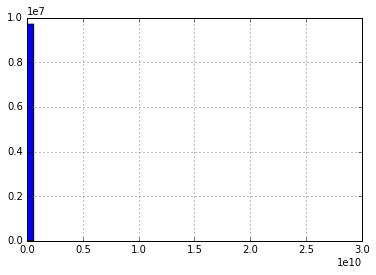

In [35]:
body_sizes.hist(bins=50)

In [16]:
large_body_sizes = body_sizes[body_sizes >= body_sizes.iloc[50000]]
large_body_sizes.shape

(50001,)

### Optional: Filter by 0.5 bodies

In [38]:
path = '/nrs/flyem/bergs/complete-ffn-agglo/bodies-0.5-including-psds-from-neuprint-52f9.csv'
focused_bodies = set(pd.read_csv(path, header=None, names=['body'])['body'])
filtered_body_sizes = body_sizes[body_sizes.index.isin(focused_bodies)]

path = f'/nrs/flyem/bergs/tmp/focused-body-sizes-{instance_info[1][:4]}.csv'
filtered_body_sizes.to_csv(path, header=True, index=True)
print(f"Wrote to {path}")

Wrote to /nrs/flyem/bergs/tmp/focused-body-sizes-ecbe.csv


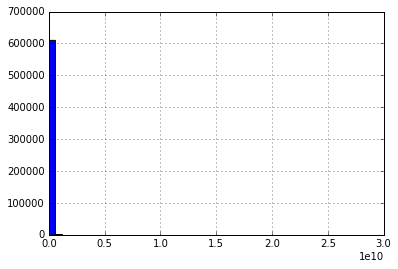

In [39]:
filtered_body_sizes.hist(bins=50)

In [40]:
filtered_body_sizes.shape

(612769,)

In [ ]:
#sizes = pd.read_csv('/nrs/flyem/bergs/tmp/focused-body-sizes-d585.csv')

In [41]:
filtered_small_body_sizes = filtered_body_sizes[filtered_body_sizes <= filtered_body_sizes.iloc[50000]]

In [42]:
filtered_small_body_sizes.shape

(562769,)

In [43]:
np.random.seed(0)
chosen_bodies = np.random.choice(filtered_small_body_sizes.index.values, size=200, replace=False)
chosen_sizes = filtered_small_body_sizes.loc[chosen_bodies]
chosen_sizes.to_csv('/nrs/flyem/bergs/orphan-link-experiment/orphan-link-experiment-bodies.csv', index=True, header=True)

In [ ]:
sizes[:10]

In [ ]:
from neuclease.dvid import *
from tqdm import tqdm_notebook

sv_count = []
exist_count = []

sizes_subset = sizes.iloc[-100:].copy()

for body in tqdm_notebook(sizes_subset):
    svs = fetch_supervoxels_for_body(*instance_info, body)
    exists = fetch_exists(instance_info[0], instance_info[1], 'segmentation_sv_meshes', svs)
    sv_count.append(len(svs))
    exist_count.append(exists.sum())

sizes_subset = sizes_subset.copy()
sizes_subset['sv_count'] = sv_count
sizes_subset['exist_count'] = exist_count
sizes_subset['exist_pct'] = 100*(sizes_subset['exist_count'] / sizes_subset['sv_count'])

In [ ]:
sizes_subset[top_sizes['exist_pct'] < 98]

In [ ]:
len(sv_count)

In [ ]:
len(exist_count)